In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Loading the Dataset

In [2]:
batch_size = 24 # here we chose a smaller batch_size to help mprove the accuracy 
img_height = 224  
img_width = 224

In [3]:
image_dir = 'UECFOOD256'

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  labels='inferred', # each folder in image_dir would represent a class so setting this to 'inferred' would give 
  color_mode="rgb",
  label_mode ='categorical', # for class names that are not represented as numeric, also an alias to caterogical-cross entropy
  validation_split=0.2,
  subset="both",
  seed=666, # to produce consistent results 
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 26944 files belonging to 211 classes.
Using 21556 files for training.
Using 5388 files for validation.
Metal device set to: Apple M1 Pro


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Modelling
- First we instaniate the pretrained model that is going to be the backbone(base model) of our transfer learning task
- Next, we freeze the entire pretrained model so the weights of the base model are not updated when we trained on top of it. (Note that CNNs are trained from bottom to top)
    - First, we have to add some data augmentation to improve generalizability of our new model as our dataset size is small compared to the one that the pretrained model is trained on. 
    - Next, we send those into a preprocess layer that transform the data into inputs that are accepted into the pretrained model. 
    - Then, we double confirmed that the pretrained model is set to untrainable but passing in training = False
    - Next, the results are collected and averaged in the global average layer
    - Next, we introduced a dropout layer to randomly remove a portion of the 'connections' made from the penultimate to the final layer.
        - This artifically removes a portion of the model's training and is often used to reduce overfitting.
    - Then, the model outputs the predictions in the prediction layer. 
    - Finally, the model is complied and ready for training

In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=False, # For transfer-learning tasks, we don't want the final layer which is responsible for producing the actual classes
    weights="imagenet",
    input_shape=(224,224,3)
)

In [7]:
from tensorflow.keras import layers

pretrained_model.trainable = False # Important!
        
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(211, activation ='softmax')

#Being able to chain the transformations is one of Keras most useful feature of the Model API

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = pretrained_model(x, training=False) # Just to double confirm
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.7)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

# Training
- A relatively high base training rate is used to help bump accuracy
- We used an EarlyStopping Callback to help monitor the validation loss and stops the training when the validation loss is no longer improving for 3 epochs

In [8]:
base_learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_ds, 
    epochs=50, 
    validation_data=val_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights =True
        )
    ]
)

Epoch 1/50
899/899 [==============================] - 67s 73ms/step - loss: 3.7067 - accuracy: 0.2494 - val_loss: 1.9110 - val_accuracy: 0.5130
Epoch 2/50
899/899 [==============================] - 65s 72ms/step - loss: 2.2806 - accuracy: 0.4449 - val_loss: 1.6752 - val_accuracy: 0.5640
Epoch 3/50
899/899 [==============================] - 66s 73ms/step - loss: 2.0417 - accuracy: 0.4976 - val_loss: 1.5745 - val_accuracy: 0.5850
Epoch 4/50
899/899 [==============================] - 66s 74ms/step - loss: 1.9051 - accuracy: 0.5245 - val_loss: 1.5258 - val_accuracy: 0.5982
Epoch 5/50
899/899 [==============================] - 64s 71ms/step - loss: 1.8302 - accuracy: 0.5427 - val_loss: 1.5030 - val_accuracy: 0.6086
Epoch 6/50
899/899 [==============================] - 65s 72ms/step - loss: 1.7766 - accuracy: 0.5564 - val_loss: 1.4805 - val_accuracy: 0.6197
Epoch 7/50
899/899 [==============================] - 65s 72ms/step - loss: 1.7376 - accuracy: 0.5685 - val_loss: 1.4729 - val_accuracy:

# Analysis of Training (Before Fine-Tuning)
- An ideal scenario is depicted below, 
    - The validation curves consistently sits below the train curve which means that the model is not overfitting; 
    - The fact that both train and validation curves are displaying signs of converging also means that underfitting is highly unlikely as well. 
- Although the accuracy is not very high right now, it is okay. We can further fine tune the model later to achieve a bump in accuracy

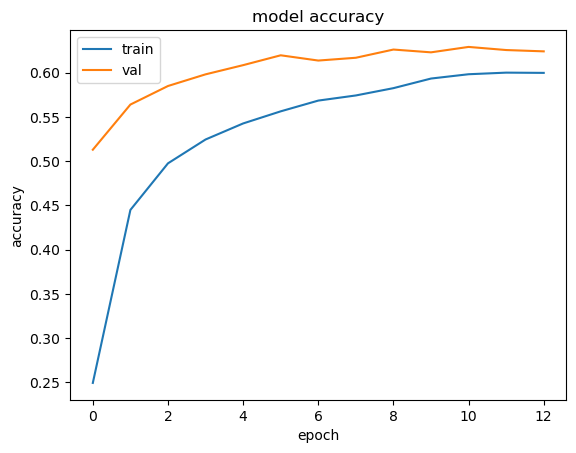

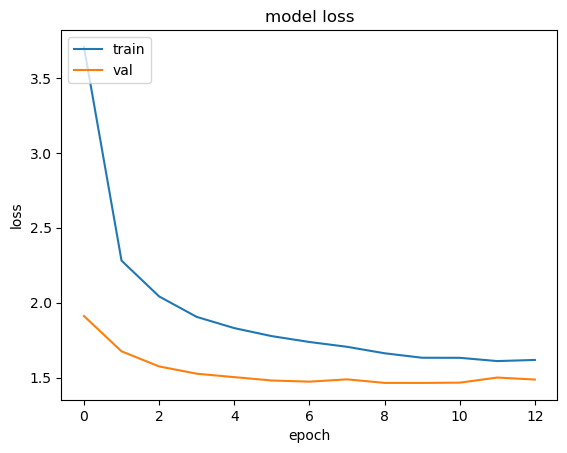

In [9]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Fine Tuning
- We first unfreeze the base model to allow the weights (params) of the pretrained model to be updatable with the current weights of the model
    - Yet, we don't want to completely retrain every single layer as well since the most bottom layers contain useful 'characteristics' of the pretrained model that are useful for general image recognition.
    - This is because the layers nearer to the top oftentimes contain 'characteristics' that are more specific to the dataset. (CNNs are trained from bottom to top) 
    - Thus, we will freeze the bottom layers of the pretrained model to ensure that we dont undo the training done for the pretrained model and unfreeze the upper layers and retrain them instead for our dataset.
- As for which layer is the 'optimal' layer to fine tune from, every dataset is different so there is no standard algorithm (not that we know of) and extensive trial and error is often employed 

In [24]:
pretrained_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                    

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/100),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_fine = model.fit(train_ds, epochs=50, validation_data=val_ds, 
        callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights =True
        )
    ])

Epoch 1/50
899/899 [==============================] - 99s 107ms/step - loss: 0.9263 - accuracy: 0.7338 - val_loss: 1.1977 - val_accuracy: 0.6867
Epoch 2/50
899/899 [==============================] - 94s 105ms/step - loss: 0.8909 - accuracy: 0.7456 - val_loss: 1.1527 - val_accuracy: 0.6995
Epoch 3/50
899/899 [==============================] - 96s 107ms/step - loss: 0.8624 - accuracy: 0.7534 - val_loss: 1.1855 - val_accuracy: 0.6862
Epoch 4/50
899/899 [==============================] - 99s 110ms/step - loss: 0.8454 - accuracy: 0.7558 - val_loss: 1.1505 - val_accuracy: 0.6930
Epoch 5/50
899/899 [==============================] - 102s 113ms/step - loss: 0.8163 - accuracy: 0.7647 - val_loss: 1.1416 - val_accuracy: 0.6980
Epoch 6/50
899/899 [==============================] - 102s 114ms/step - loss: 0.8169 - accuracy: 0.7610 - val_loss: 1.1563 - val_accuracy: 0.6945
Epoch 7/50
899/899 [==============================] - 101s 112ms/step - loss: 0.7758 - accuracy: 0.7739 - val_loss: 1.1379 - val

# Analysis of Training (After Fine-Tuning)
- The curves below is a classic example of overfitting
    - Notice how in both graphs, the train curve completely sits above the val curve ? This means that the model is displaying signs of memorizing instead of generalizing.
- Though, this is expected behaviour that is associated with the fine-tuning stage of a typical transfer learning task.
- This is why we induce a slower learning rate and used Keras's EarlyStopping callbacks to stop the training when it detects that the validation losses is not improving for 3 epochs. 
- This is not ideal but acceptable due to high accuracy rates of both train and validation. (Note that the margins are exaggerated so when the curves are displayed on a different margins the overfitting will not appear to be so obvious.)

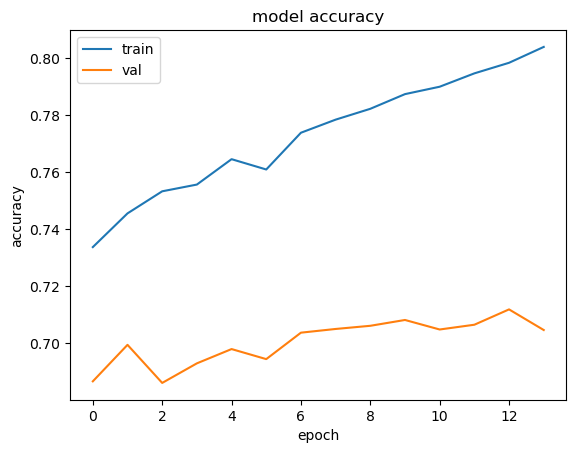

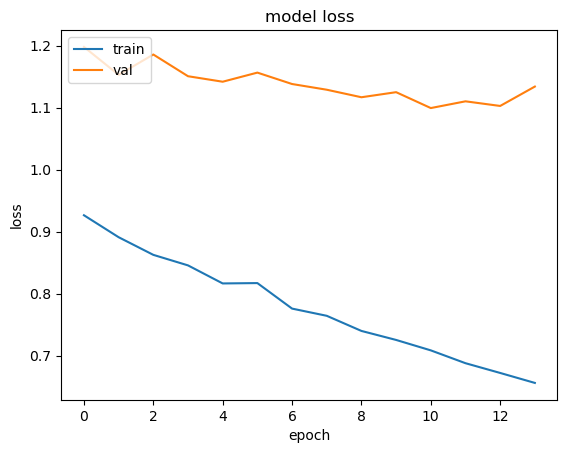

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Learning Points/Area for improvements
For V3, accuracy/underfitting is not the main concern. The main issue for this version is overfitting.

Overall, there is two main areas of improvements, with the Dataset having the highest cost and highest value. 
A well labelled image datasets are not common. One that has sufficient size is even rarer. 
Thus, we will prioritize hyperparameter tweaking. 
- Hyperparameters(from highest to lowest value )
    - Dropout rate/Regularization
    - Base learning rate
    - Optimal layer for fine-tuning

- Dataset
    - Improve size and quality

# Saving Model

In [29]:
model.save('model_v3')

INFO:tensorflow:Assets written to: model_v4/assets


INFO:tensorflow:Assets written to: model_v4/assets
